In [1]:
import pandas as pd
import networkx as nx
from networkx.drawing.nx_pydot import write_dot
import matplotlib.pyplot as plt
from matplotlib import patches
import re
import datetime

import seaborn as sns
import operator
import numpy as np

%matplotlib inline
%load_ext line_profiler

#Load the data
dep = pd.read_csv('clean_dep.csv', index_col = 0 )

#Convert to date time object
dep['package_date'] = pd.to_datetime(dep['package_date'])

In [11]:
#print(dep.describe())

print(dep[(dep['package_name'] == 'csv')])

                           package_id package_name package_version  \
csv@0.4.0@csv-generate      csv@0.4.0          csv           0.4.0   
csv@0.4.0@csv-parse         csv@0.4.0          csv           0.4.0   
csv@0.4.0@csv-stringify     csv@0.4.0          csv           0.4.0   
csv@0.4.0@stream-transform  csv@0.4.0          csv           0.4.0   
csv@0.4.1@csv-generate      csv@0.4.1          csv           0.4.1   
csv@0.4.1@csv-parse         csv@0.4.1          csv           0.4.1   
csv@0.4.1@csv-stringify     csv@0.4.1          csv           0.4.1   
csv@0.4.1@stream-transform  csv@0.4.1          csv           0.4.1   
csv@0.4.2@csv-generate      csv@0.4.2          csv           0.4.2   
csv@0.4.2@csv-parse         csv@0.4.2          csv           0.4.2   
csv@0.4.2@csv-stringify     csv@0.4.2          csv           0.4.2   
csv@0.4.2@stream-transform  csv@0.4.2          csv           0.4.2   
csv@0.4.4@csv-generate      csv@0.4.4          csv           0.4.4   
csv@0.4.4@csv-parse 

In [13]:
#Build the graph helper function
def make_graph(df, min_edges=0):
    DG = nx.DiGraph()
    DG.add_nodes_from(df.package_id.unique())
    edges = df.loc[df.dependency_id.notnull(), ['package_id', 'dependency_id']].values
    DG.add_edges_from(edges)
    
    #Remove NULL
    DG.remove_nodes_from(['.', 'nan', np.nan])

    #Remove nodes if min degree is set
    deg = DG.degree()
    to_remove = [n for n in deg if deg[n] <= min_edges]
    DG.remove_nodes_from(to_remove)
    return DG

In [ ]:
# Make a dotfile to import into gephi and make the network graph
%lprun -f make_graph DG = make_graph(dep, min_edges=10)
write_dot(DG, 'dep_final.dot')
print(nx.info(DG))

In [ ]:
#Set up date df
listofdates = {
'data2012Q4':'2013-01-01',
'data2013Q1':'2013-03-01',
'data2013Q2':'2013-06-01',
'data2013Q3':'2013-09-01',
'data2013Q4':'2014-01-01',
'data2014Q1':'2014-03-01',
'data2014Q2':'2014-06-01',
'data2014Q3':'2014-09-01',
'data2014Q4':'2015-01-01',
'data2015Q1':'2015-03-01',
'data2015Q2':'2015-06-01',
'data2015Q3':'2015-09-01',
'data2015Q4':'2016-01-01',
'data2016Q1':'2016-03-01',
'data2016Q2':'2016-06-01',
'data2016Q3':'2016-09-01',
'data2016Q4':'2017-01-01',
'data2017Q1':'2017-03-01',
'data2017Q2':'2017-06-01'}

dfofdates = pd.DataFrame.from_dict(listofdates, orient='index')

In [ ]:
#Create a CSV with the degree of a package
degree_dict = {}
print ('Start Time: ' + str(datetime.datetime.now()))

for index, row in dfofdates.iterrows():
    period = row.get_values().item()
    n = 0
    
    #filter by date
    data = dep[(dep['package_date'] < row[0])]
    
    #make the graph
    graph = make_graph(data, min_edges=1)
    
    #sort it
    sorted_dict = sorted(graph.in_degree().items(), key=operator.itemgetter(1))[::-1]
    
    #select the top 20
    while n < 500:
        degree_dict[sorted_dict[n]] = {'period': period, 'name': sorted_dict[n][0],'degree': sorted_dict[n][1] }
        n = n + 1
        
print ('End Time: ' + str(datetime.datetime.now()))

degree_df = pd.DataFrame.from_dict(degree_dict, orient='index')
degree_df.to_csv('degree_df.csv')

print ('CSV Time: ' + str(datetime.datetime.now()))

In [ ]:
#Create a CSV with the page rank
page_rank_dict = {}

for index, row in dfofdates.iterrows():
    period = row.get_values().item()
    n = 0
    
    #filter by date
    data = dep[(dep['package_date'] < row[0])]
    
    #make the graph
    graph = make_graph(data, min_edges=1)
    
    #sort it
    pr = nx.link_analysis.pagerank_scipy(graph)
    sorted_dict = sorted(pr.items(), key=operator.itemgetter(1))[::-1]
    
    #select the top 20
    while n < 500:
        page_rank_dict[sorted_dict[n]] = {'period': period, 'name': sorted_dict[n][0],'degree': sorted_dict[n][1] }
        n = n + 1
        
          
page_rank_df = pd.DataFrame.from_dict(page_rank_dict, orient='index')
page_rank_df.to_csv('page_rank_df.csv')

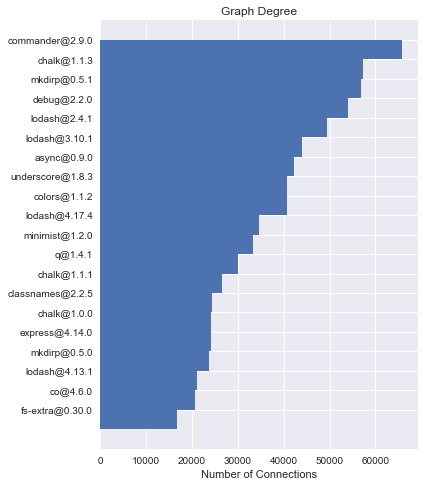

In [14]:
#Histogram of the number of connections for the top several packages

#filter by date
data = dep[(dep['package_date'] < '2017-06-01')]

#make the graph
graph = make_graph(data, min_edges=1)

#sort it
sorted_dict = sorted(graph.in_degree().items(), key=operator.itemgetter(1))[::-1]

#Create graph
N = 20
x = np.arange(N)
y = np.array([d[1] for d in sorted_dict[:N]])
xlabels = [d[0] for d in sorted_dict[:N]][::-1]
fig, ax = plt.subplots(1, 1, figsize=(7, 7))

ax.barh(x[::-1], y, height=1.0)
ax.set_yticks(x + 0.5)
_ = ax.set_yticklabels(xlabels)
ax.set_xlabel('Number of Connections')
ax.set_title('Graph Degree')
fig.subplots_adjust(left=0.27, bottom=0.1, top=0.95)

fig.savefig('Figures/Connections.png')

In [ ]:
#General graph to use of current packages

#filter by date
data = dep[(dep['package_date'] < '2014-06-01')]

#make the graph
dep_graph = make_graph(data, min_edges=0)

len(dep_graph.node)

In [ ]:
#Degree Distribution plot

deg = dep_graph.degree()

bins=30
fig, ax = plt.subplots(1, 1, figsize=(11,4))
ax.hist(list(deg.values()), bins=bins, normed=False)
ax.plot(ax.get_xlim(), [1, 1], 'k--', alpha=0.5)
ax.set_xlabel('Degree')
ax.set_ylabel('Number')
ax.set_title('Degree Distribution')
ax.set_yscale('log')
ax.set_ylim((0.5, 1e5))

fig.subplots_adjust(left=0.1, bottom=0.15)
fig.savefig('Figures/DegreeDistribution.png')

In [ ]:
#Small World Graph Calculation

avg_pathlen = []
subgraph_size = []
for subgraph in nx.connected_component_subgraphs(dep_graph.to_undirected()):
    n = len(subgraph)
    if n > 1:
        subgraph_size.append(n)
        avg_pathlen.append(nx.average_shortest_path_length(subgraph))

avg_clustering = nx.average_clustering(dep_graph.to_undirected())
apl = np.average(avg_pathlen, weights=subgraph_size)
print(apl, avg_clustering)